In [2]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
ckd = Table.read_table('data/ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.sample(5).show()

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
42,70,1.025,0,0,normal,normal,notpresent,notpresent,75,31,1.2,141,3.5,16.5,54,7800,6.2,no,no,no,good,no,no,0
66,70,1.02,0,0,normal,normal,notpresent,notpresent,94,19,0.7,135,3.9,16,41,5300,5.9,no,no,no,good,no,no,0
59,70,1.01,1,3,abnormal,abnormal,notpresent,notpresent,424,55,1.7,138,4.5,12.6,37,10200,4.1,yes,yes,yes,good,no,no,1
60,80,1.025,0,0,normal,normal,notpresent,notpresent,131,10,0.5,146,5,14.5,41,10700,5.1,no,no,no,good,no,no,0
62,80,1.02,0,0,normal,normal,notpresent,notpresent,132,34,0.8,147,3.5,17.8,44,4700,4.5,no,no,no,good,no,no,0


In [4]:
ckd.group('Class')

Class,count
0,115
1,43


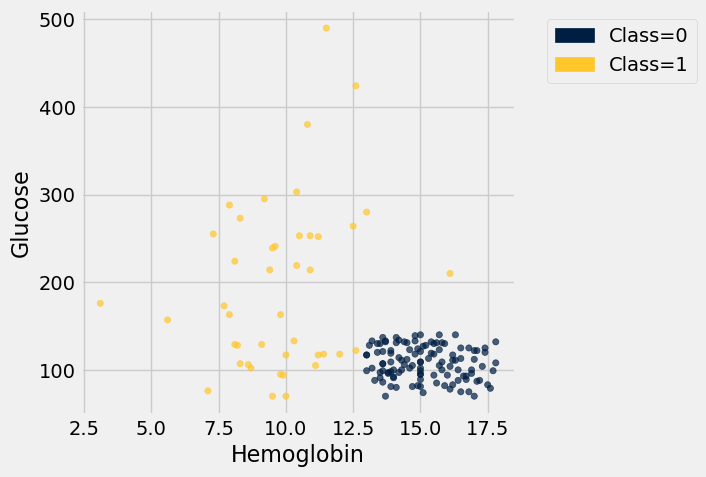

In [5]:
ckd.scatter('Hemoglobin', 'Glucose', group='Class')

In [6]:
max_glucose_for_0 = ckd.where('Class',are.equal_to(0)).column('Glucose').max()
min_hemoglobin_for_0 = ckd.where('Class',are.equal_to(0)).column('Hemoglobin').min()

max_glucose_for_0, min_hemoglobin_for_0

(140, 13.0)

In [7]:
def classify_manually(hemoglobin, glucose):
    if hemoglobin < min_hemoglobin_for_0 or glucose > max_glucose_for_0:
        return 1
    else:
        return 0

In [8]:
classify_manually(15, 100)

0

In [9]:
classify_manually(10, 300)

1

In [10]:
banknotes = Table.read_table('data/banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


In [11]:
banknotes.group('Class')

Class,count
0,762
1,610


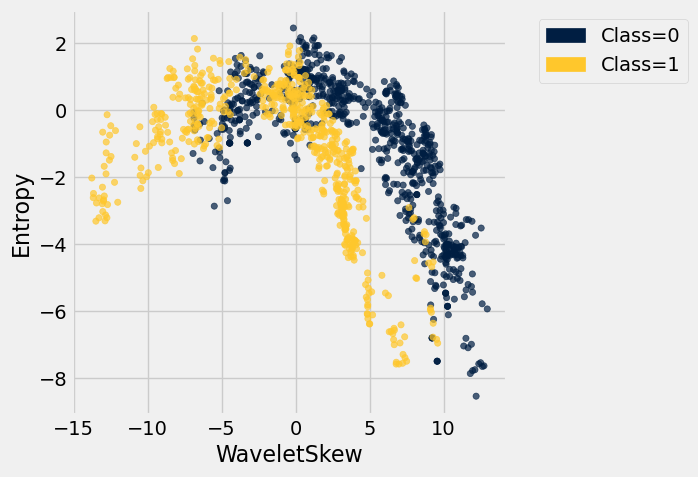

In [12]:
banknotes.scatter('WaveletSkew', 'Entropy', group='Class')

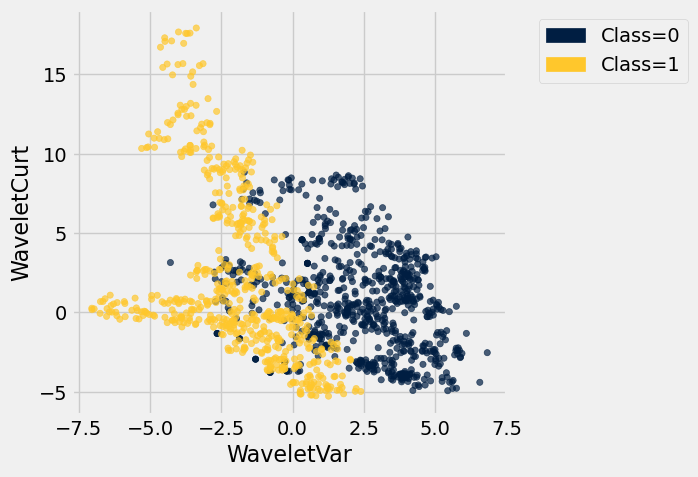

In [13]:
banknotes.scatter('WaveletVar', 'WaveletCurt', group='Class')

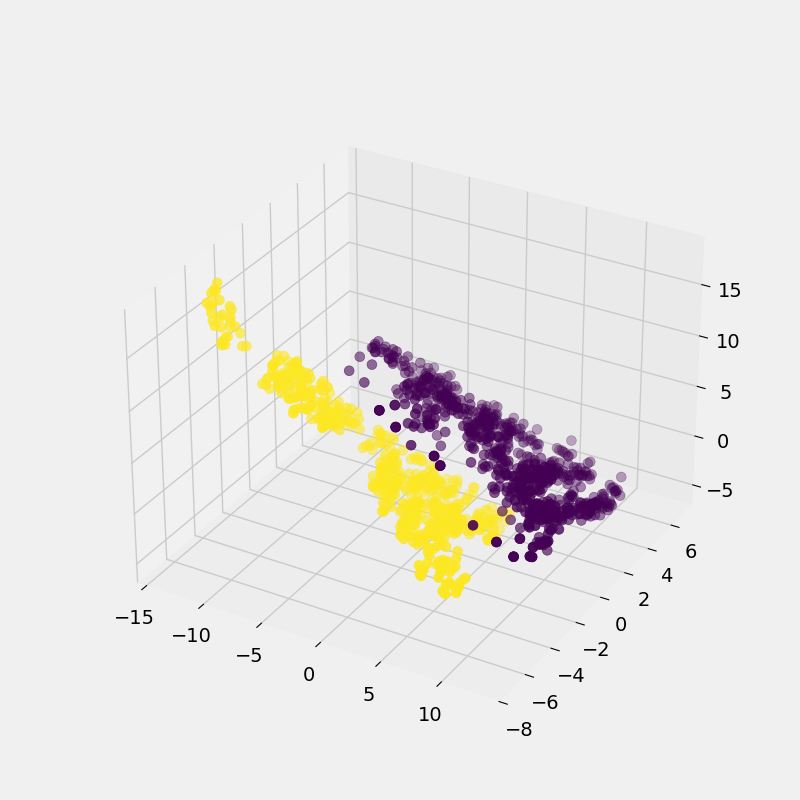

In [24]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Class'),
           cmap='viridis',
          s=50);

In [139]:
# don't worry about any of this right now

%matplotlib inline

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))

def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

def show_closest(point):
    """point = array([x,y]) 
    gives the coordinates of a new point
    shown in red"""
    
    HemoGl = ckd.select('Hemoglobin', 'Glucose')
    t = closest(HemoGl, point, 1)
    x_closest = t.row(0).item(0)
    y_closest = t.row(0).item(1)
    ckd.scatter('Hemoglobin', 'Glucose', group='Class')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot(make_array(point.item(0), x_closest), make_array(point.item(1), y_closest), color='k', lw=2);


def plot_all_points(test_grid):
    test_grid.scatter('Hemoglobin', 'Glucose', color='red', alpha=0.4, s=30)

    plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Class'), edgecolor='k')

    plt.xlim(-2, 2)
    plt.ylim(-2, 2);
    
def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

def plot_all_points_classified(test_grid):
    c = classify_grid(ckd.drop('White Blood Cell Count'), test_grid, 1)
    test_grid = test_grid.with_column('Class', c)
    test_grid.scatter('Hemoglobin', 'Glucose', group='Class', alpha=0.4, s=30)
    
    plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Class'), edgecolor='k')

    plt.xlim(-2, 2)
    plt.ylim(-2, 2);

In [140]:
ckd = Table.read_table('data/ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)

# color_table = Table().with_columns(
#     'Class', make_array(0, 1),
#     'Color', make_array('darkblue', 'gold')
# )
# ckd = ckd.join('Class', color_table)
ckd

Hemoglobin,Glucose,White Blood Cell Count,Class
-0.865744,-0.221549,-0.569768,1
-1.45745,-0.947597,1.16268,1
-1.00497,3.84123,-1.27558,1
-2.81488,0.396364,0.809777,1
-2.08395,0.643529,0.232293,1
-1.35303,-0.561402,-0.505603,1
-0.413266,2.04928,0.360623,1
-1.28342,-0.947597,3.34429,1
-1.10939,1.87936,-0.409356,1
-1.35303,0.489051,1.96475,1


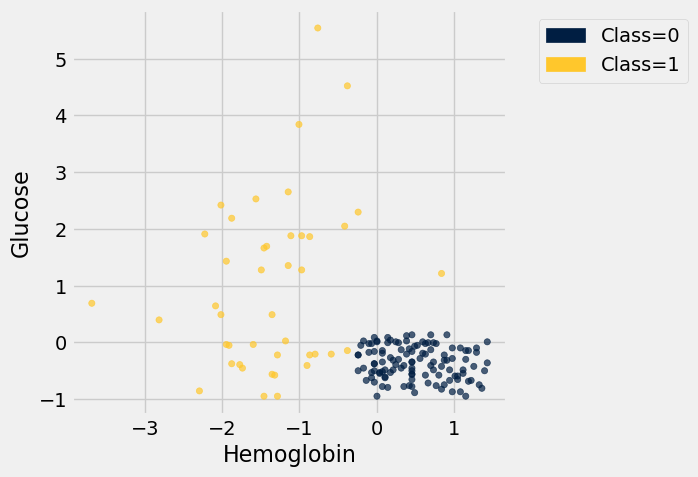

In [141]:
ckd.scatter('Hemoglobin', 'Glucose', group='Class')

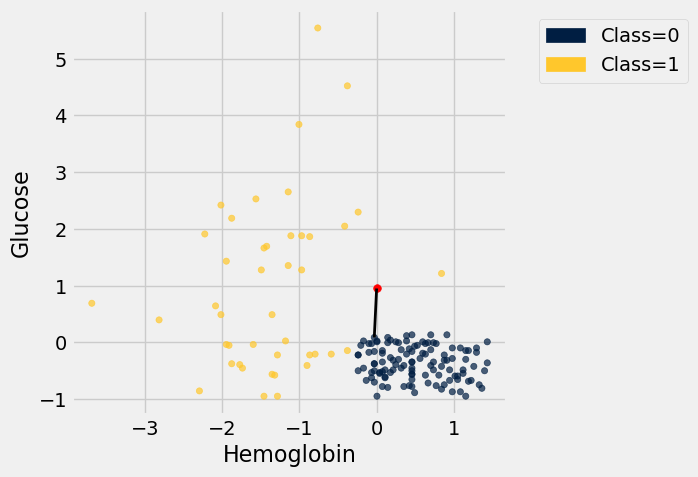

In [142]:
alice = make_array(0, 0.95)
show_closest(alice)

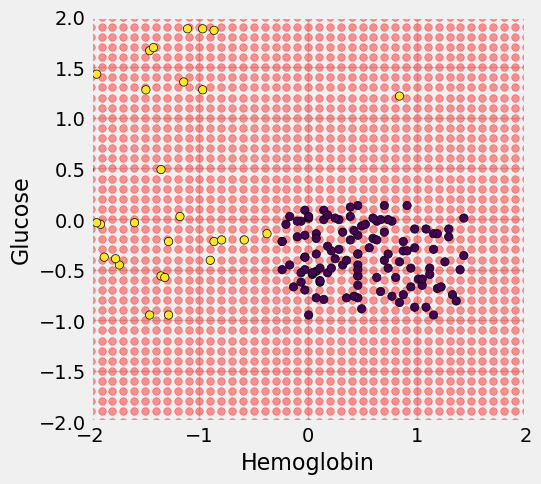

In [143]:
x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)

test_grid = Table().with_columns(
    'Hemoglobin', x_array,
    'Glucose', y_array
)

plot_all_points(test_grid)

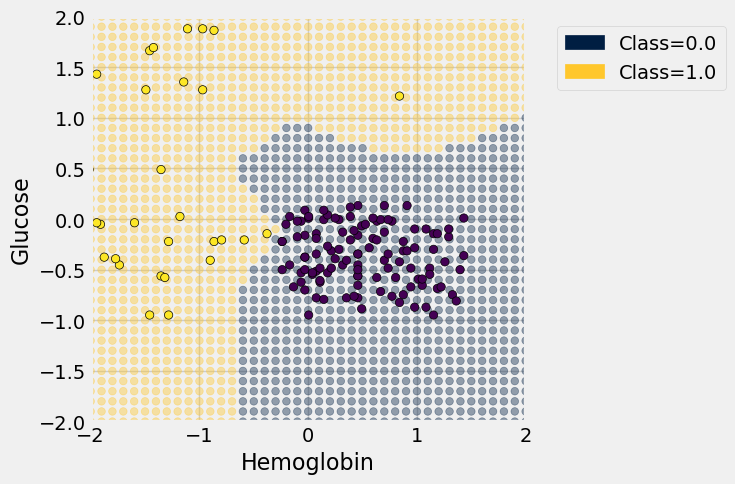

In [144]:
plot_all_points_classified(test_grid)

In [145]:
shuffled_ckd = ckd.sample(with_replacement=False)

training = shuffled_ckd.take(np.arange(79))
testing = shuffled_ckd.take(np.arange(79, 158))

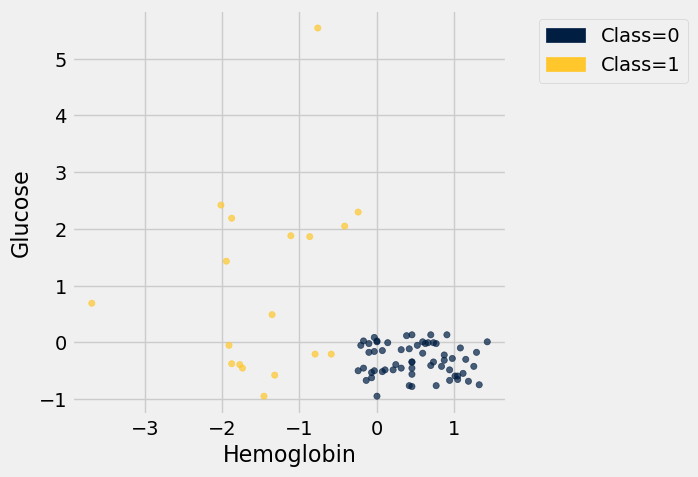

In [146]:
training.scatter('Hemoglobin', 'Glucose', group='Class')

---

In [163]:
ckd = Table.read_table('data/ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd = ckd.select('Hemoglobin', 'Glucose', 'Class')
ckd

Hemoglobin,Glucose,Class
11.2,117,1
9.5,70,1
10.8,380,1
5.6,157,1
7.7,173,1
9.8,95,1
12.5,264,1
10,70,1
10.5,253,1
9.8,163,1


In [164]:
alice = make_array(0,1.1)
alice

array([ 0. ,  1.1])

In [165]:
ckd.row(0)

Row(Hemoglobin=11.199999999999999, Glucose=117, Class=1)

In [166]:
type(ckd.row(0))

datascience.tables.Row

In [167]:
ckd.row(0).item(1)

117

In [168]:
np.array(ckd.row(0)) # make_array doesn't work for conversion

array([  11.2,  117. ,    1. ])

In [169]:
patient = ckd.drop('Class').row(0)
patient

Row(Hemoglobin=11.199999999999999, Glucose=117)

In [170]:
np.array(patient)

array([  11.2,  117. ])

In [171]:
(alice.item(0) - patient.item(0)) ** 2 + (alice.item(1) - patient.item(1)) ** 2

13558.250000000002

In [172]:
alice - np.array(patient)

array([ -11.2, -115.9])

In [173]:
(alice - np.array(patient)) ** 2

array([   125.44,  13432.81])

In [174]:
np.sum((alice - np.array(patient)) ** 2)

13558.250000000002

In [175]:
np.sum((alice - np.array(patient)) ** 2) ** 0.5

116.43989866021012

In [176]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sum((point1-point2)**2) ** 0.5

In [177]:
distance(alice, np.array(patient))

116.43989866021012